# MNIST Recognition

![logo](http://simonwinder.com/wp-content/uploads/2015/07/mnistExamples.png)

In [11]:
# Usual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import random

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import manifold

# Keras
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop, Adam
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import MaxPooling2D,ZeroPadding2D,Conv2D

# Tensorflow
import tensorflow as tf

## Introduction
The MNIST dataset is made of : 
- 55 000 samples
- Written digits (0 - 9) : 10 classes

Each sample is a 784 = 28 * 28 pixel values, as show in the image below

![img](https://www.tensorflow.org/versions/r0.10/images/MNIST-Matrix.png)

## References

##### Only about MNIST
- For the tensorflow part, and many images https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/index.html#mnist-for-ml-beginners
- For the keras part https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

##### Others
- On cross-entropy http://colah.github.io/posts/2015-09-Visual-Information/

***
# Preparing the data

## Loading dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## How many samples do we have ?

In [3]:
X = mnist.train.images
y = mnist.train.labels

print(X.shape)
print(y.shape)

(55000, 784)
(55000, 10)


##### We need the targets labels

In [4]:
titles = np.array([list(x).index(1) for x in y])
titles[:20]

array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8, 0, 3, 1, 2, 7, 0, 2, 9, 6, 0])

## Visualizing the data

### Displaying one image

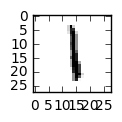

In [5]:
img = random.choice(X)

def plot_sample(array,title = ""):
    plt.figure(figsize=(1, 1))
    plt.title(title)
    plt.imshow(array.reshape((28,28)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

plot_sample(img)

### Displaying a gallery of images

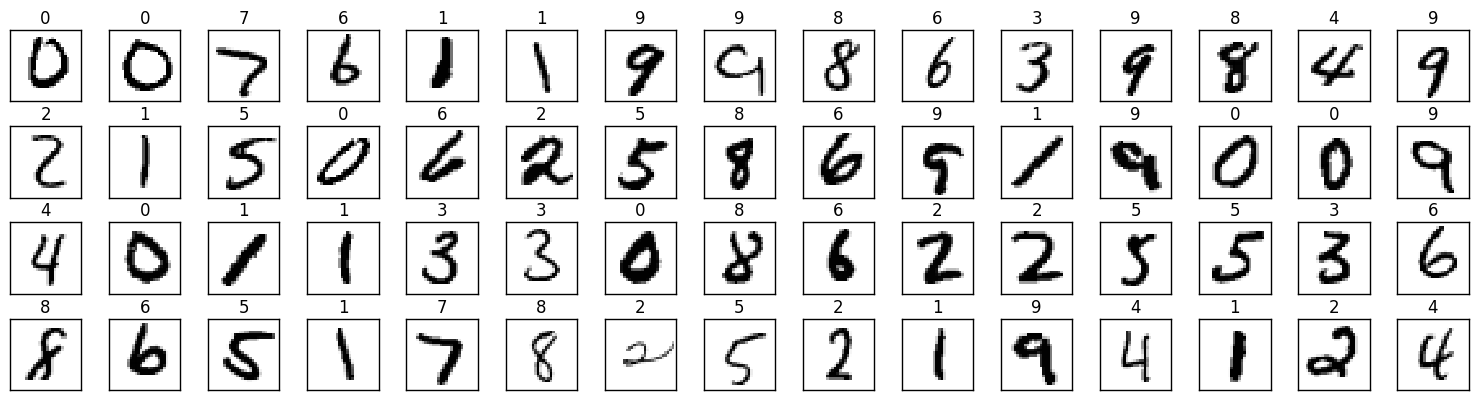

In [6]:
selection = np.random.randint(0,len(X),60)

def plot_gallery(images, titles = None,n_row=4, n_col=15):
    if titles is None:
        titles = ["" for i in range(len(images))]
        
    #Helper function to plot a gallery of portraits
    plt.figure(figsize=(1.0 * n_col, 1.0 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((28,28)),cmap=plt.cm.gray_r,interpolation="nearest")
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()
        
plot_gallery(X[selection],titles[selection])

### Displaying clusters of images with TSNE

In [131]:
def plot_embedding(X, n_pictures = 25,title="t-SNE embedding"):
    
    # TAKING A RANDOM SAMPLE
    selection = np.random.randint(0,len(X),n_pictures)
    
    # T-SNE EMBEDDING
    print("Computing t-SNE embedding")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X[selection])
    
    # NORMALIZING
    x_min, x_max = np.min(X_tsne, 0), np.max(X_tsne, 0)
    X_tsne = (X_tsne - x_min) / (x_max - x_min)
    
    # FIGURE
    plt.figure(figsize = (15,15))
    ax = plt.subplot(111)
    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])  # just something big
        for j,i in enumerate(selection):
            dist = np.sum((X_tsne[j] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-5:
                continue
            shown_images = np.r_[shown_images, [X_tsne[j]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X[i].reshape((28,28)), cmap=plt.cm.gray_r),
                X_tsne[j])
            ax.add_artist(imagebox)
            
    # REMOVE THE TICKS
    plt.xticks([]), plt.yticks([])
    plt.show()

Computing t-SNE embedding


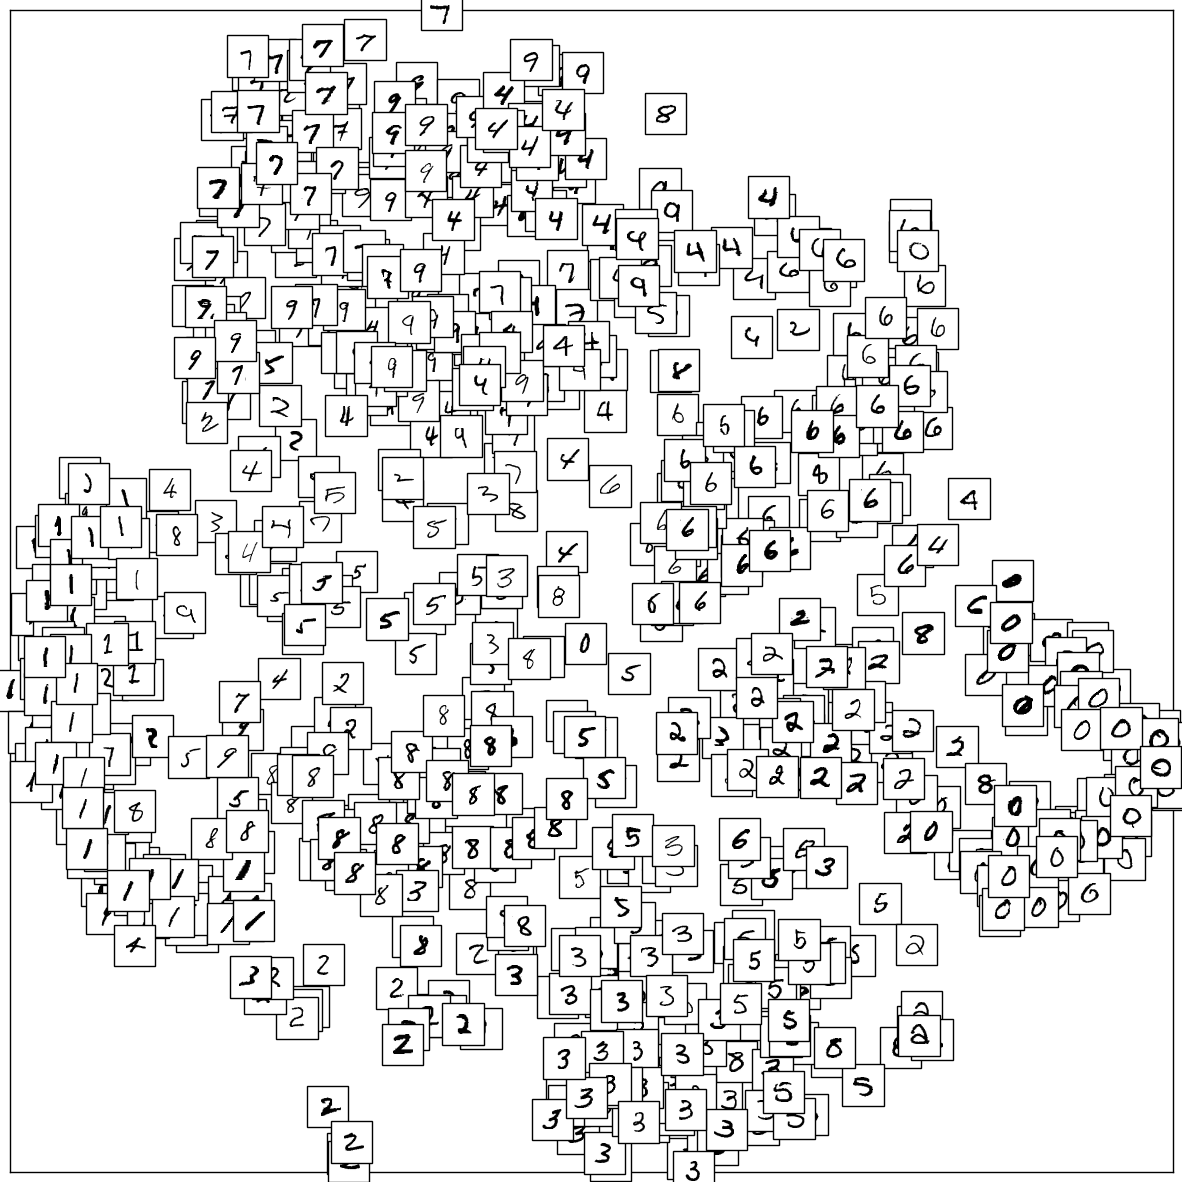

In [135]:
plot_embedding(X,1000)

## Train Test Split

In [17]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y,test_size = 0.3)

print(X_train.shape)
print(X_test.shape)

(38500, 784)
(16500, 784)


##### Some libraries like scikit learn need not to have one hot vectors

In [18]:
t_train = np.array([list(x).index(1) for x in y_train])
t_test = np.array([list(x).index(1) for x in y_test])

***
# Simple logistic regression

## With Sklearn

### Training

In [25]:
from sklearn.linear_model import LogisticRegression

In [34]:
%%time
LR = LogisticRegression(n_jobs = 4,verbose = 1)
LR.fit(X_train,t_train)

[LibLinear]Wall time: 56.5 s


### Performances

In [37]:
prediction = LR.predict(X_test)

We can reach a **low accuracy of 92.2%** with a Logistic Regression from Sklearn

In [38]:
accuracy_score(t_test,prediction)

0.92212121212121212

## With Keras
![logo_keras](https://upload.wikimedia.org/wikipedia/commons/c/c9/Keras_Logo.jpg)

### Instantiate the model

In [40]:
model = Sequential()
model.add(Dense(10,input_dim = 784))
model.add(Activation('softmax'))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

### Training

In [49]:
%%time
model.fit(X_train,y_train,validation_split=0.1)

Train on 34650 samples, validate on 3850 samples
Epoch 1/10
34650/34650 [==============================] - 1s - loss: 0.2612 - acc: 0.9288 - val_loss: 0.2403 - val_acc: 0.9296
Epoch 2/10
34650/34650 [==============================] - 1s - loss: 0.2592 - acc: 0.9295 - val_loss: 0.2774 - val_acc: 0.9153
Epoch 3/10
34650/34650 [==============================] - 1s - loss: 0.2564 - acc: 0.9300 - val_loss: 0.2444 - val_acc: 0.9358
Epoch 4/10
34650/34650 [==============================] - 1s - loss: 0.2575 - acc: 0.9272 - val_loss: 0.2805 - val_acc: 0.9278
Epoch 5/10
34650/34650 [==============================] - 1s - loss: 0.2528 - acc: 0.9305 - val_loss: 0.2949 - val_acc: 0.9114
Epoch 6/10
34650/34650 [==============================] - 1s - loss: 0.2512 - acc: 0.9308 - val_loss: 0.2662 - val_acc: 0.9325
Epoch 7/10
34650/34650 [==============================] - 1s - loss: 0.2510 - acc: 0.9314 - val_loss: 0.2819 - val_acc: 0.9223
Epoch 8/10
34650/34650 [==============================] - 1s -

### Performances

In [50]:
prediction = model.predict_classes(X_test)

16160/16500 [============================>.] - ETA: 0s

The **accuracy is not better** than sklearn's but it is **way faster**

In [51]:
accuracy_score(t_test,prediction)

0.92133333333333334

## With Tensorflow
![logo_tf](https://www.tensorflow.org/_static/images/tensorflow/logo.png)

### Instantiating the model
This part is almost a copy-paste of the official tutorial at https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/index.html#mnist-for-ml-beginners <br>
Yet, it has many more information, it is nice to have a look at that

#### Implementing the regression : forward pass

##### Define the placeholders for the Input variables, weights and bias

In [55]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

##### Define the forward pass : WX+b followed by a softmax function
![forward](https://www.tensorflow.org/versions/r0.10/images/softmax-regression-vectorequation.png)

In [60]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

#### Training : Implementing the backward pass

##### Define the loss function as categorical crossentropy

In [61]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

##### Prepare the backpropagation algorithm through Gradient Descent to minimize the cross entropy

In [62]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

### Training and prediction in a session

In [67]:
# Initialize all tensorflow variables
init = tf.global_variables_initializer()

# Number of episodes
n_episodes = 1000

# Launch session
with tf.Session() as sess:
    sess.run(init)
    
    # Run the train step 1000 times
    for i in range(n_episodes):
        print("\r[{}/{}] train step".format(i+1,n_episodes),end = "")
        
        # Taking a random batch of 100 samples 
        selection = np.random.randint(0,len(X_train),100) 
        
        # Run the step
        sess.run(train_step, feed_dict={x: X_train[selection], y_: y_train[selection]})
    print("")
    
    
    # Accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

[1000/1000] train step
0.9168


We reach **again a ~92% accuracy** with Tensorflow

***

# Feed Forward Neural Network

## With Keras

### Instantiate the model

#### 1 hidden layer

In [40]:
model = Sequential()
model.add(Dense(100,input_dim = 784))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

#### 2 hidden layers

In [41]:
model2 = Sequential()
model2.add(Dense(100,input_dim = 784))
model2.add(Activation('relu'))
model2.add(Dense(100))
model2.add(Activation('relu'))
model2.add(Dense(10))
model2.add(Activation('softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

### Training

In [42]:
%%time
model.fit(X_train,y_train,validation_split=0.1,epochs=15)

Train on 34650 samples, validate on 3850 samples
Epoch 1/15
34650/34650 [==============================] - 2s - loss: 0.3818 - acc: 0.8894 - val_loss: 0.2380 - val_acc: 0.9301
Epoch 2/15
34650/34650 [==============================] - 2s - loss: 0.1910 - acc: 0.9464 - val_loss: 0.1785 - val_acc: 0.9506
Epoch 3/15
34650/34650 [==============================] - 2s - loss: 0.1361 - acc: 0.9614 - val_loss: 0.1482 - val_acc: 0.9566
Epoch 4/15
34650/34650 [==============================] - 2s - loss: 0.1038 - acc: 0.9709 - val_loss: 0.1249 - val_acc: 0.9647
Epoch 5/15
34650/34650 [==============================] - 2s - loss: 0.0821 - acc: 0.9772 - val_loss: 0.1137 - val_acc: 0.9681
Epoch 6/15
34650/34650 [==============================] - 2s - loss: 0.0680 - acc: 0.9815 - val_loss: 0.1099 - val_acc: 0.9668
Epoch 7/15
34650/34650 [==============================] - 2s - loss: 0.0558 - acc: 0.9851 - val_loss: 0.0982 - val_acc: 0.9730
Epoch 8/15
34650/34650 [==============================] - 2s -

In [43]:
%%time
model2.fit(X_train,y_train,validation_split=0.1,epochs=15)

Train on 34650 samples, validate on 3850 samples
Epoch 1/15
34650/34650 [==============================] - 2s - loss: 0.3608 - acc: 0.8945 - val_loss: 0.2098 - val_acc: 0.9340
Epoch 2/15
34650/34650 [==============================] - 3s - loss: 0.1537 - acc: 0.9541 - val_loss: 0.1579 - val_acc: 0.9478
Epoch 3/15
34650/34650 [==============================] - 2s - loss: 0.0983 - acc: 0.9703 - val_loss: 0.1176 - val_acc: 0.9639
Epoch 4/15
34650/34650 [==============================] - 2s - loss: 0.0708 - acc: 0.9787 - val_loss: 0.1084 - val_acc: 0.9673
Epoch 5/15
34650/34650 [==============================] - 2s - loss: 0.0525 - acc: 0.9842 - val_loss: 0.0912 - val_acc: 0.9753
Epoch 6/15
34650/34650 [==============================] - 2s - loss: 0.0388 - acc: 0.9883 - val_loss: 0.0895 - val_acc: 0.9740
Epoch 7/15
34650/34650 [==============================] - 2s - loss: 0.0296 - acc: 0.9913 - val_loss: 0.0829 - val_acc: 0.9784
Epoch 8/15
34650/34650 [==============================] - 2s -

### Performances

In [49]:
prediction = model.predict_classes(X_test)

15776/16500 [===========================>..] - ETA: 0s

In [45]:
prediction2 = model2.predict_classes(X_test)

14816/16500 [=========================>....] - ETA: 0s

In [50]:
accuracy_score(t_test,prediction)

0.98284848484848486

In [47]:
accuracy_score(t_test,prediction2)

0.98521212121212121

- The neural network is way better than the logistic regression, **reaching 98% accuracy in only 15 epochs**
- A deeper (2 hidden layers) neural network here is little more accurate 

### Visualize the hidden layers

There are 4 sets of weights for the 1-hidden layer model :  
- Input Layer and biases
- Hidden Layer and biases

In [82]:
weights = model.get_weights()
first_layer = weights[0]
print("Sets of weights : ",len(weights))

for w in weights:
    print(w.shape)

Sets of weights :  4
(784, 100)
(100,)
(100, 10)
(10,)


In [83]:
len(first_layer)

784

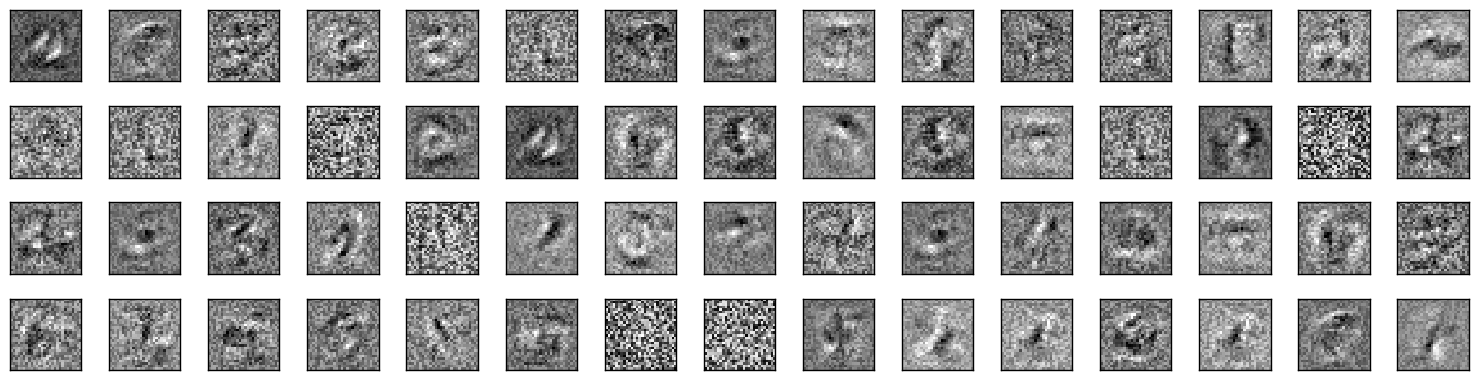

In [97]:
selection = np.random.randint(0,first_layer.shape[1],60)

plot_gallery(list(first_layer[:,selection].transpose()))

## With Tensorflow

SOON

***

# Convolutional Neural Network

## With Keras

### Creating and training the model

In [26]:
def CNN_model(input_dim = (28,28,1),output_dim = 10):
    model = Sequential()

    model.add(Conv2D(32, (3,3), padding ='same',input_shape=input_dim))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding ='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim))
    model.add(Activation('softmax'))

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

    return model

model = CNN_model()

In [27]:
model.fit(X_train.reshape((len(X_train),28,28,1)),y_train,validation_split=0.1,epochs=10)

Train on 34650 samples, validate on 3850 samples
Epoch 1/10
34650/34650 [==============================] - 171s - loss: 0.2071 - acc: 0.9360 - val_loss: 0.0602 - val_acc: 0.9842
Epoch 2/10
34650/34650 [==============================] - 171s - loss: 0.0798 - acc: 0.9766 - val_loss: 0.0407 - val_acc: 0.9899
Epoch 3/10
34650/34650 [==============================] - 173s - loss: 0.0647 - acc: 0.9812 - val_loss: 0.0562 - val_acc: 0.9831
Epoch 4/10
34650/34650 [==============================] - 176s - loss: 0.0572 - acc: 0.9841 - val_loss: 0.0489 - val_acc: 0.9873
Epoch 5/10
34650/34650 [==============================] - 171s - loss: 0.0519 - acc: 0.9866 - val_loss: 0.0426 - val_acc: 0.9891
Epoch 6/10
34650/34650 [==============================] - 173s - loss: 0.0474 - acc: 0.9862 - val_loss: 0.0485 - val_acc: 0.9914
Epoch 7/10
34650/34650 [==============================] - 174s - loss: 0.0490 - acc: 0.9868 - val_loss: 0.0439 - val_acc: 0.9922
Epoch 8/10
34650/34650 [========================

### Performances

In [28]:
prediction = model.predict_classes(X_test.reshape((len(X_test),28,28,1)))

16480/16500 [============================>.] - ETA: 0s

A simple CNN model can **reach a high 99.2% accuracy**

In [30]:
accuracy_score(t_test,prediction)

0.99230303030303035

### Visualizing the hidden layers

SOON

##### Looking at the hidden layers

In [35]:
len(model.get_weights())

12

In [37]:
for weights_set in model.get_weights():
    print(weights_set.shape)

(3, 3, 1, 32)
(32,)
(3, 3, 32, 32)
(32,)
(3, 3, 32, 64)
(64,)
(3, 3, 64, 64)
(64,)
(1600, 512)
(512,)
(512, 10)
(10,)


### Conclusions

SOON

## With Tensorflow

SOON

# More to come

- More coverage on different libraries with PyTorch and Caffe2
- More complex architecture